# <font color='blue'>Time Series Transformer </font>

## <font color='blue'>Matemática da Arquitetura Transformer na Análise e Forecast de Séries Temporais</font>

### Este notebook demonstra como aplicar a arquitetura transformer para análise e previsão de séries temporais

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Importando Bibliotecas e Configuração

Vamos começar importando todas as bibliotecas 

In [3]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# GluonTS
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch import DeepAREstimator
from gluonts.torch import SimpleFeedForwardEstimator
from gluonts.torch import TemporalFusionTransformerEstimator
from gluonts.torch import WaveNetEstimator

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Utilidadaes
from datetime import datetime, timedelta
from tqdm.auto import tqdm
import json
from typing import List, Dict, Optional, Tuple
import math

# Configuração de visualização
plt.style.use('seaborn-v0_8') 
sns.set_palette("husl")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed para reprodutividade
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

print(f"Dispositivo: {device}")
print("Setup concluído!")

Dispositivo: cuda
Setup concluído!


## 2. Fundamentos Teóricos - Attention Mechanism

In [4]:
class MultiHeadAttention(nn.Module):
   """Implementação customizada de Multi-Head Attention para demonstração"""

   def __init__(self, d_model: int, num_heads: int = 8, dropout: float = 0.1):
      super().__init__()
      assert d_model % num_heads == 0

      self.d_model = d_model
      self.num_heads = num_heads
      self.d_k = d_model // num_heads

      # Projeções lineares para Q, K, V
      self.W_q = nn.Linear(d_model, d_model)
      self.W_k = nn.Linear(d_model, d_model)
      self.W_v = nn.Linear(d_model, d_model)
      self.W_o = nn.Linear(d_model, d_model)

      self.dropout = nn.Dropout(dropout)
      self.scale = math.sqrt(self.d_k)
   
   def scaled_dot_product_attention(self, Q, K, V, mask=None):
      """Atenção escalada produto escalar"""
      # Q, K, V: [batch_size, num_heads, seq_len, d_k]

      scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

      if mask is not None:
         scores.masked_fill_(mask == 0, -1e9)
      
      attention_weights = F.softmax(scores, dim=-1)
      attention_weights = self.dropout(attention_weights)

      output = torch.matmul(attention_weights, V)

      return output, attention_weights

   def forward(self, query, key, value, mask=None):
      batch_size = query.size(0)

      Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
      K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
      V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

      attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

      attention_output = attention_output.transpose(1, 2).contiguous().view(
         batch_size, -1, self.d_model
      )

      output = self.W_o(attention_output)
      return output, attention_weights

print("Multi-Head Attention implementando!")

d_model, num_heads = 128, 8
seq_len, batch_size = 24, 2

attention = MultiHeadAttention(d_model, num_heads)
x = torch.randn(batch_size, seq_len, d_model)

output, weights = attention(x, x, x)
print(f"Input: {x.shape} -> Output: {output.shape}")
print(f"Attention weights: {weights.shape}")

Multi-Head Attention implementando!
Input: torch.Size([2, 24, 128]) -> Output: torch.Size([2, 24, 128])
Attention weights: torch.Size([2, 8, 24, 24])


## 3. Positional Encoding Para Séries Temporais

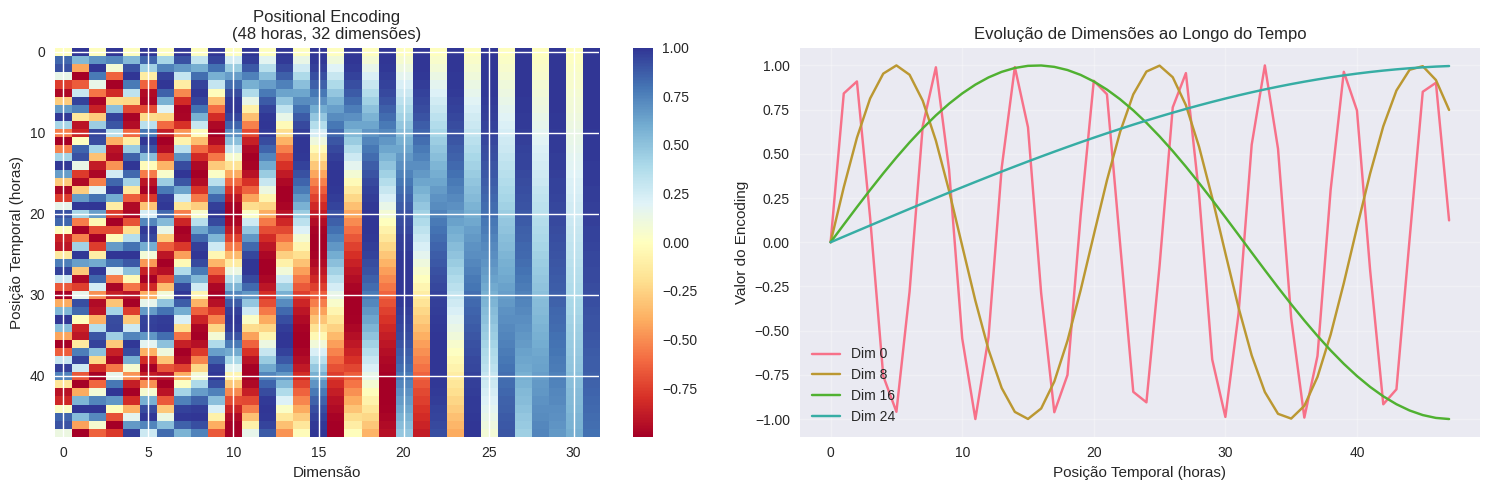

In [5]:
class TimeSeriesPositionlEncoding(nn.Module):
   """Positional Encoding otimizado para séries temporais"""

   def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
      super().__init__()
      self.dropout = nn.Dropout(dropout)

      pe = torch.zeros(max_len, d_model)
      position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)

      div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)

      self.register_buffer('pe', pe.unsqueeze(0))

   def forward(self, x):
      x = x + self.pe[:, :x.size(1), :]
      return self.dropout(x)

pe = TimeSeriesPositionlEncoding(d_model=64, max_len=168)
pe_matrix = pe.pe.squeeze().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

im1 = ax1.imshow(pe_matrix[:48, :32], cmap='RdYlBu', aspect='auto')
ax1.set_title('Positional Encoding\n(48 horas, 32 dimensões)')
ax1.set_xlabel('Dimensão')
ax1.set_ylabel('Posição Temporal (horas)')
plt.colorbar(im1, ax=ax1)

for i in range(0, 32, 8):
   ax2.plot(pe_matrix[:48, i], label=f'Dim {i}')
ax2.set_title('Evolução de Dimensões ao Longo do Tempo')
ax2.set_xlabel('Posição Temporal (horas)')
ax2.set_ylabel("Valor do Encoding")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Geração de Dados Sintéticos

In [6]:
def create_synthetic_time_series(n_series=10, n_points=1000, freq='H'):
   """Cria séries temporais sintéticas com padrões realistas"""

   data = []
   start_date = pd.Timestamp('2020-01-01')

   for series_id in range(n_series):
      t = np.arange(n_points)
      trend = 0.001 * t * np.random.uniform(0.5, 2.0)
      daily_season = 5 * np.sin(2 * np.pi * t / 24) * np.random.uniform(0.8, 1.2)
      weekly_season = 3 * np.sin(2 * np.pi * t / 168) * np.random.uniform(0.7, 1.3)
      yearly_season = 2 * np.sin(2 * np.pi * t / (365 * 24)) * np.random.uniform(0.5, 1.5)
      noise = np.random.normal(0, 1, n_points)
      values = 50 * trend + daily_season + weekly_season + yearly_season + noise
      timestamps = pd.date_range(start=start_date, periods=n_points, freq=freq)

      series_df = pd.DataFrame({
         'timestamp': timestamps,
         'value': values,
         'series_id': series_id
      })

      data.append(series_df)
   
   return pd.concat(data, ignore_index=True)

print("GERANDO DADOS SINTÉTICOS...")
df = create_synthetic_time_series(n_series=5, n_points=2000, freq='H')

print("Dataset criado: ")
print(f"Shape: {df.shape}")
print(f"Período: {df['timestamp'].min()} até {df['timestamp'].max()}")
print(f"Séries: {df['series_id'].nunique()}")

GERANDO DADOS SINTÉTICOS...
Dataset criado: 
Shape: (10000, 3)
Período: 2020-01-01 00:00:00 até 2020-03-24 07:00:00
Séries: 5
